# Tarefa 6: Análise de Reclamações de clientes

## Problema

> Você trabalha como analista de dados em uma grande empresa que está preocupada
com o aumento do núumero de queixas ou reclamaçõoes registradas por consumidores.
Sua equipe foi encarregada de investigar os fatores que levam os consumidores a abrir
uma queixa contra a empresa, utilizando dados reais de um conjunto disponível em
[Análise de Personalidade de Consumidores](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis).

## Análise exploratória

Antes de mais nada, baixemos os dados:

In [1]:
import kagglehub
import pandas as pd
from pathlib import Path

path = Path(kagglehub.dataset_download("imakash3011/customer-personality-analysis"))

filename = next(path.glob('*'))
df = df_raw = pd.read_csv(path/filename, sep='\t')
df.infer_objects(copy=False)
print(f'Number of rows: {len(df)}')
pd.DataFrame(dict(columns=df.columns))

Number of rows: 2240


columns
0                    ID
1            Year_Birth
2             Education
3        Marital_Status
4                Income
5               Kidhome
6              Teenhome
7           Dt_Customer
8               Recency
9              MntWines
10            MntFruits
11      MntMeatProducts
12      MntFishProducts
13     MntSweetProducts
14         MntGoldProds
15    NumDealsPurchases
16      NumWebPurchases
17  NumCatalogPurchases
18    NumStorePurchases
19    NumWebVisitsMonth
20         AcceptedCmp3
21         AcceptedCmp4
22         AcceptedCmp5
23         AcceptedCmp1
24         AcceptedCmp2
25             Complain
26        Z_CostContact
27            Z_Revenue
28             Response

Temos 28 colunas. Nosso interesse é criar um modelo que, a partir das outras, possa deduzir o valor de `Complain`. O significado de cada coluna pode ser visto na tabela abaixo:

### Tabelas de colunas
#### Dados pessoas

| Coluna         | Descrição                                           | Tipo de dado |
|----------------|----------------------------------------------------|---------------|
| ID             | Identificador único do cliente                     | int           |
| Year_Birth     | Ano de nascimento do cliente                       | int           |
| Education      | Nível de escolaridade do cliente                   | str           |
| Marital_Status | Estado civil do cliente                            | str           |
| Income         | Renda anual da família do cliente                  | float         |
| Kidhome        | Número de crianças na casa do cliente              | int           |
| Teenhome       | Número de adolescentes na casa do cliente          | int           |
| Dt_Customer    | Data de cadastro do cliente na empresa             | datetime      |
| Recency        | Número de dias desde a última compra do cliente    | int           |
| Complain       | 1 se o cliente reclamou nos últimos 2 anos, 0 caso contrário | int (binário) |

#### Produtos

| Coluna           | Descrição                                           | Tipo de dado |
|------------------|----------------------------------------------------|---------------|
| MntWines         | Valor gasto em vinhos nos últimos 2 anos           | float         |
| MntFruits        | Valor gasto em frutas nos últimos 2 anos           | float         |
| MntMeatProducts  | Valor gasto em produtos de carne nos últimos 2 anos| float         |
| MntFishProducts  | Valor gasto em produtos de peixe nos últimos 2 anos| float         |
| MntSweetProducts | Valor gasto em doces nos últimos 2 anos            | float         |
| MntGoldProds     | Valor gasto em produtos de ouro nos últimos 2 anos | float         |

#### Promoções

| Coluna            | Descrição                                               | Tipo de dado |
|-------------------|--------------------------------------------------------|---------------|
| NumDealsPurchases | Número de compras feitas com desconto                  | int           |
| AcceptedCmp1      | 1 se o cliente aceitou a oferta na 1ª campanha, 0 caso contrário | int (binário) |
| AcceptedCmp2      | 1 se o cliente aceitou a oferta na 2ª campanha, 0 caso contrário | int (binário) |
| AcceptedCmp3      | 1 se o cliente aceitou a oferta na 3ª campanha, 0 caso contrário | int (binário) |
| AcceptedCmp4      | 1 se o cliente aceitou a oferta na 4ª campanha, 0 caso contrário | int (binário) |
| AcceptedCmp5      | 1 se o cliente aceitou a oferta na 5ª campanha, 0 caso contrário | int (binário) |
| Response          | 1 se o cliente aceitou a oferta na última campanha, 0 caso contrário | int (binário) |

#### Canais

| Coluna             | Descrição                                             | Tipo de dado |
|--------------------|------------------------------------------------------|---------------|
| NumWebPurchases    | Número de compras feitas pelo site da empresa        | int           |
| NumCatalogPurchases| Número de compras feitas pelo catálogo               | int           |
| NumStorePurchases  | Número de compras feitas diretamente nas lojas       | int           |
| NumWebVisitsMonth  | Número de visitas ao site da empresa no último mês   | int           |

Como podemos notar, possuímos várias informações, desde aspectos do relacionamento (como número de uso de canais da empresa, resposta a promoções etc.) até aspectos pessoais bem íntimos, o que é meio assustador mas esse é o mundo em que vivemos.

Este dataset foi projetado para categorizar clientes (i.e. clusterização). Nosso objetivo, porém, é antever quando um cliente fará uma reclamação. Faremos isto utilizando modelos supervisionados. Se conseguirmos encontrar modelos com alta previsibilidade, a empresa será capaz de identificar fatores e tratá-los apropriadamente.

Investiguemos cada coluna, começando com os rótulos:

### Coluna `Complain`

Vamos analisar primero a coluna cujos valores queremos prever, `Complain`. Quantos clientes reclamararam?

In [2]:

complaints = df['Complain'].unique()

complain_df = pd.DataFrame({
    'Complain': complaints,
    'count': [len(df[df['Complain'] == c]) for c in complaints]
})
complain_df


Complain  count
0         0   2219
1         1     21

Essa é uma discrepância muito grande. Precisaremos fazer algum tipo de balanceamento. Por ora, estamos apeans investigando, então essa informação é relevante para sabermos que

> Em alguns casos, poderá ser necessário utilizar escala logarítmica para analisar os dados.

Como `Complain` é basicamente uma coluna categórica, vamos adicionar uma versão dela como string para uso em análise.

In [3]:
df['Complain:category'] = df['Complain'].astype(str)

### Colunas `Z_CostContact` e `Z_Revenue`

A documentação não explica as colunas `Z_CostContact` e  `Z_Revenue`, então vamos analisá-las. Antes de mais nada, vamos ver quais são seus valores:

In [4]:
df['Z_CostContact'].unique()

array([3])

In [5]:
df['Z_Revenue'].unique()

array([11])

Ambas as colunas possuem valores constantes para todas as linhas, de modo que elas não podem influenciar o resultado. Vamos removê-las do dataset

In [6]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

### Coluna `ID`

A coluna identificadora `ID` é apenas um identificador numérico para cada cliente:

In [7]:
df['ID'].head()

0    5524
1    2174
2    4141
3    6182
4    5324
Name: ID, dtype: int64

Como ela também não agrega nenhuma informação que nos ajude a prever reclamações, vamos removê-la:

In [8]:
df.drop(['ID'], axis=1, inplace=True)

### Coluna `Year_Birth`

O ano de nascimento do cliente pode ser viso na coluna `Year_Birth`. Vejamos como se distribuem:

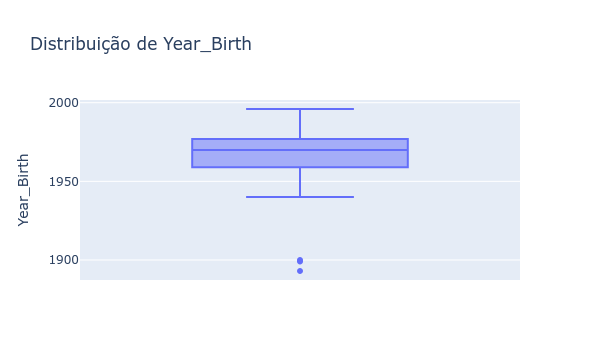

In [9]:
import plotly.express as px

def boxplot(df, column):
    fig = px.box(df, y=column, title=f"Distribuição de {column}")
    fig.show()

boxplot(df, 'Year_Birth')

Os valores oscilan de 1940 a 1996, nas há outliners: 1893, 1899 and 1900. 

In [10]:
df[df['Year_Birth'] < 1940][['Year_Birth', 'Complain']]

Year_Birth  Complain
192        1900         1
239        1893         0
339        1899         0

Eles podem ser valores corretos, ou erros de entrada. De uma forma ou de outra, são valores extremos e com pouca representação, então podemos retirá-los da base:

In [11]:
df = df[df['Year_Birth'] > 1900]

Com isso, podemos analisar o gráffico da distribuição de idades:

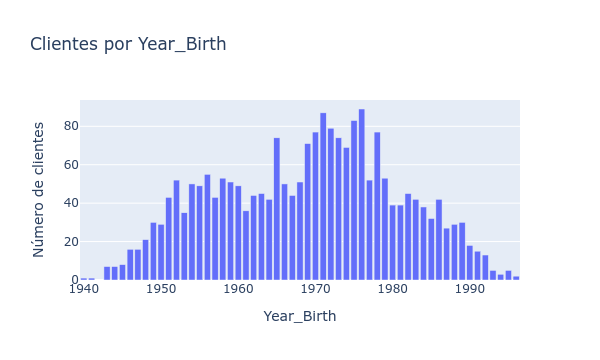

In [12]:
def count_bars(df, column):
    counting = df[column].value_counts().sort_index()
    fig = px.bar(
        x=counting.index,
        y=counting.values,
        labels={'x': column, 'y': 'Número de clientes'},
        title=f'Clientes por {column}'
    )
    
    fig.show()

count_bars(df, 'Year_Birth')

O gráfico mostra uma distribuiçaõ, se não exatamente normal, com caudas e um pico, mesmo que não um único pico. Vejamos as proporções de reclamações:

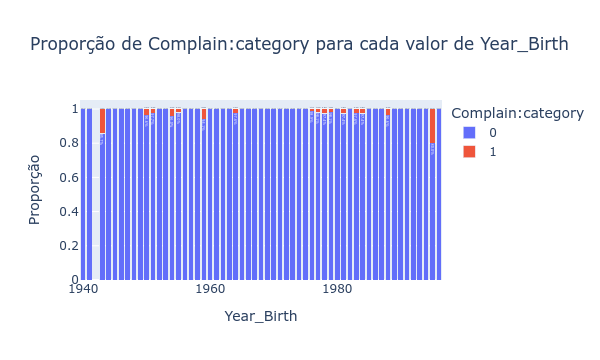

In [13]:
def proportion_bars(df, column, proportion_column='Complain:category'):
    counts = df.groupby(
        [column, proportion_column], observed=True
    ).size().reset_index(name='count')
    
    # Compute proportions within each year
    counts['proportion'] = (
        counts
            .groupby(column, observed=True)['count']
            .transform(lambda x: x / x.sum())
    )
    
    # Plot stacked bar chart
    fig = px.bar(
        counts,
        x=column,
        y='proportion',
        color=proportion_column,
        title=f'Proporção de {proportion_column} para cada valor de {column}',
        text_auto='.1%',
    )
    
    fig.update_layout(
        barmode='stack',
        yaxis_title='Proporção',
        xaxis_title=column
    )
    fig.show()

proportion_bars(df, 'Year_Birth')

O número de reclamações parece razoavelmenet distribuído pelas idades.

### Coluna `Education`

O nível de escolaridade do cliente é definido pela coluna `Education`. Estes são os valores usados:

In [14]:
df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

Abaixo, segue-se uma explicação;

| Valor      | Significado / Descrição                                                            |
| ---------- | ---------------------------------------------------------------------------------- |
| Basic      | Educação básica, equivalente ao ensino fundamental ou inicial.                     |
| 2n Cycle   | Segundo ciclo de estudos; ensino médio ou técnico. |
| Graduation | Graduação completa, nível universitário.              |
| Master     | Pós-graduação stricto sensu, nível de mestrado.                           
|
| PhD        | Doutorado, nível mais alto de formação acadêmica.                                  |



Aqui vai sua distribuição:

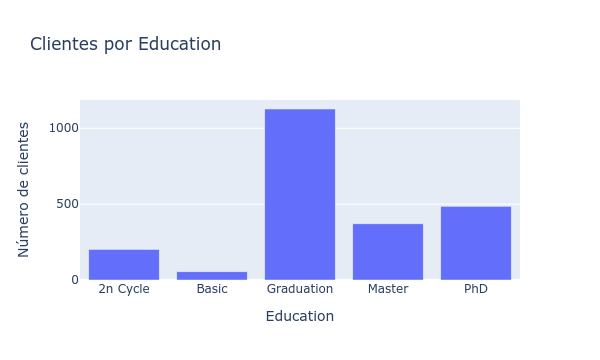

In [15]:
count_bars(df, 'Education')

A proporção de de reclamações:

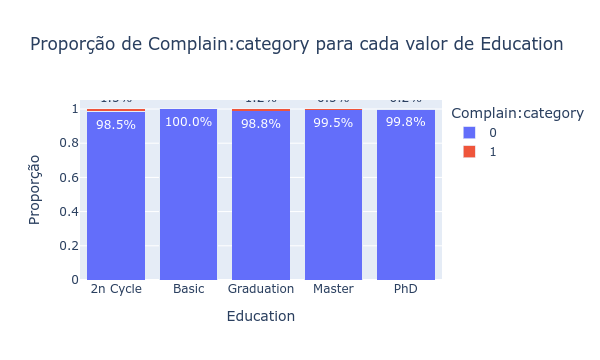

In [16]:
proportion_bars(df, 'Education')

As poucas reclamações são novamente relativamente bem distribuídas, embora nenhuma ocorra no nível básico

### Coluna `Marital_Status`

Essa coluna se refere ao estado civil do cliente. Esses são seus valores, que são bem auto-evidentes:

In [17]:
df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

Sua distribuição e proporção:

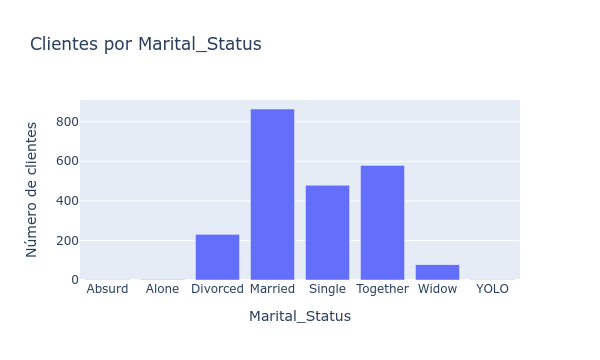

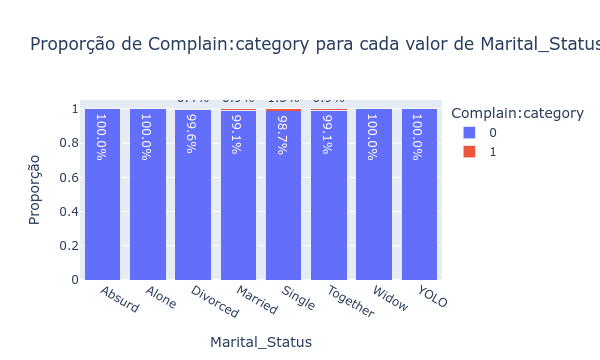

In [18]:
count_bars(df, 'Marital_Status')
proportion_bars(df, 'Marital_Status')

Curiosamente, as reclamações só acontecem em estados "reais" (isto é, estados civis que não são humorísticos.) Solteiros fazem mais reclamações.

### Coluna `Income`

A renda é um valor numérico, então vejamos sua distribuição com um boxplot:

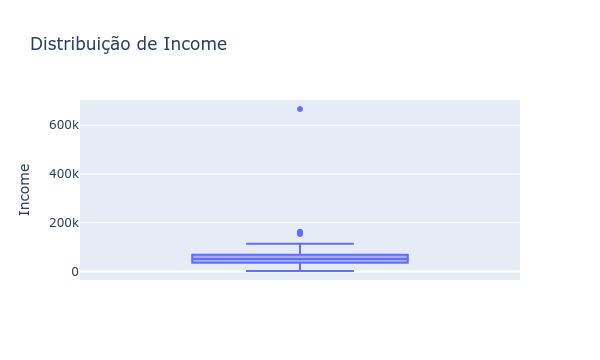

In [19]:
boxplot(df, 'Income')

Os valores se distribuem de quase $ 1200 a quase $ 160 000. Mas á um outlier de $ 600 000. Esse valor é muito discrepante dos demais:

In [20]:
df[df['Income'] > 200000][['Income', 'Complain']]

Income  Complain
2233  666666.0         0

Acreditamos que será melhor removê-lo:

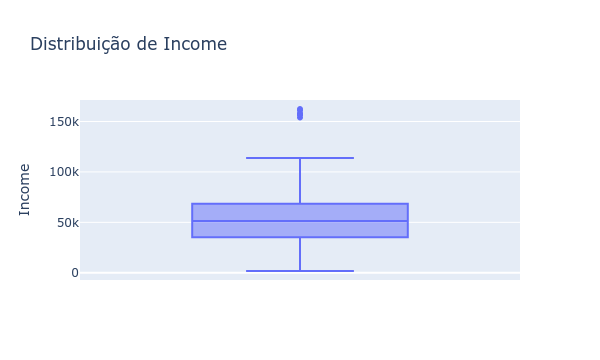

In [21]:
df = df[df['Income'] < 200000].copy()

boxplot(df, 'Income')

Vejamos sua distribuição e proporções, usando buckets:

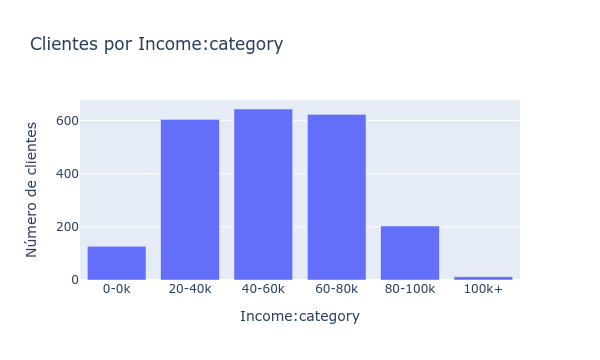

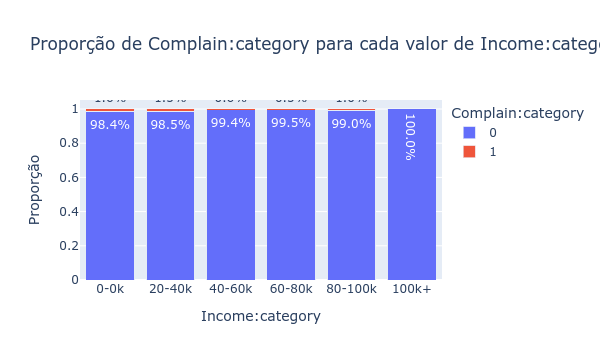

In [22]:
bins = [0, 20000, 40000, 60000, 80000, 100000, 200000]
labels = ['0-0k','20-40k','40-60k','60-80k','80-100k','100k+']
df['Income:category'] = pd.cut(df['Income'], bins=bins, labels=labels, include_lowest=True)

count_bars(df, 'Income:category')
proportion_bars(df, 'Income:category')

As reclamações es~tao relativamente bem distribuídas, com clientes mais abastados reclamando menos.

### Colunas `Kidhome` e `Teenhome`

Essas duas colunas representam o número de crianças  pequenas e adolescentes na casa:

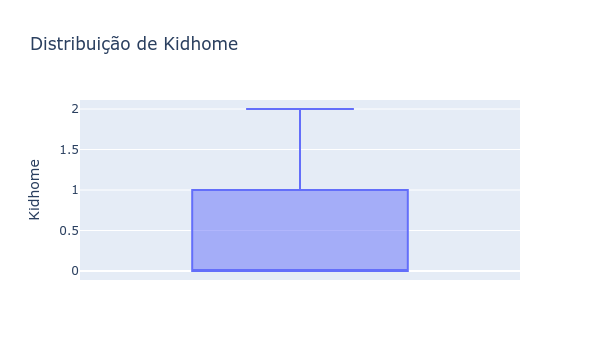

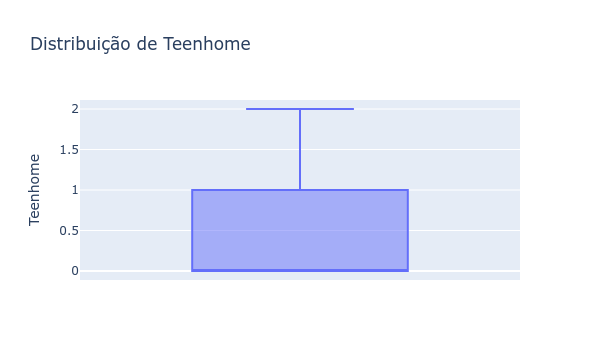

In [23]:
boxplot(df, 'Kidhome')
boxplot(df, 'Teenhome')

Clientes têm relativente pouco filhos. Vejamos a distribuição e as proporções.


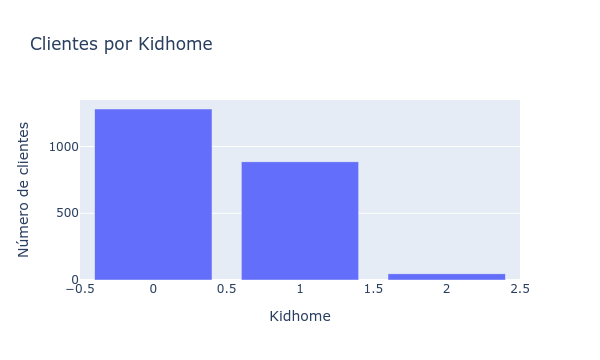

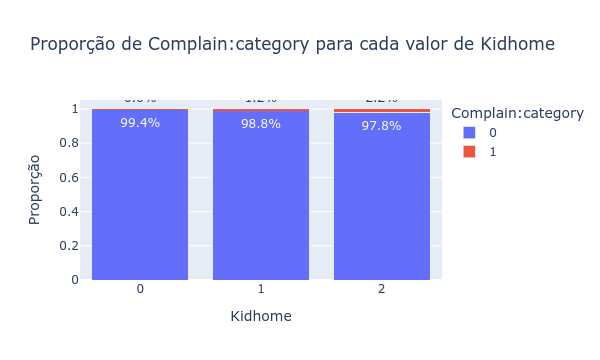

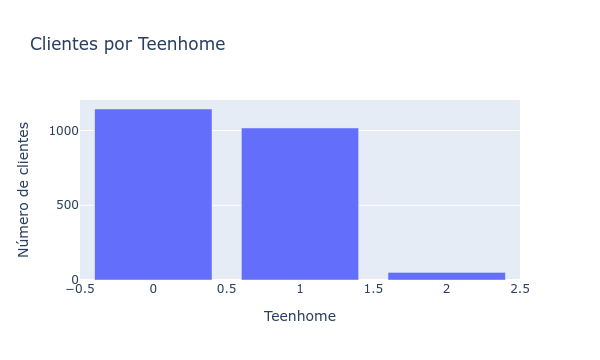

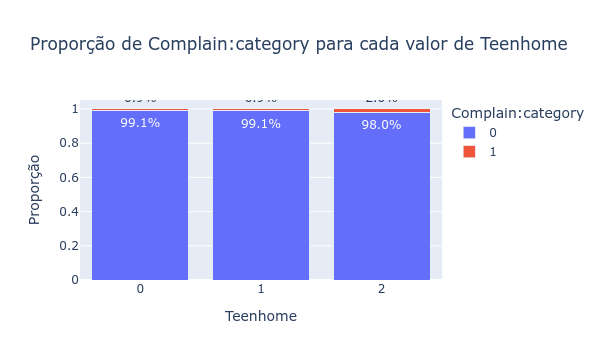

In [24]:
count_bars(df, 'Kidhome')
proportion_bars(df, 'Kidhome')
count_bars(df, 'Teenhome')
proportion_bars(df, 'Teenhome')

Aparentemente, o número de filhos pouco afeta a reclação.

### Coluna `Dt_Customer` 

Essa é a data de cadastro do cliente, enquanto `Recency` é a data da última compra. São boms indicadores do tempo de relacionamento. Vejamos como a data de cadastro se distribui:

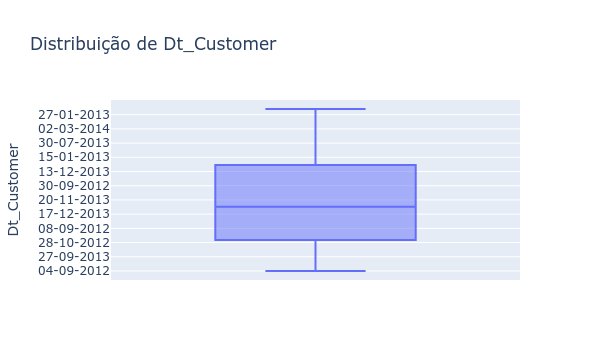

In [25]:
boxplot(df, 'Dt_Customer')

A data de cadastro dos clientes varia em um período curto, de setembro de 2012 a janeiro de 2013, enquanto a recorrência varia de 0 a cem dias. 

Isso me faz suspeitar que **esses dados foram coletados pouco depois de ser possível cadastrá-los**

**IDEIA**: Seria interessante ter da data da *última reclamação*. Poderíamos comparar com o cadastro. Há boa chance de as reclamações levarem a cadastros.

Vejamos sua distribuição da data de cadastro, novamente usando bins:

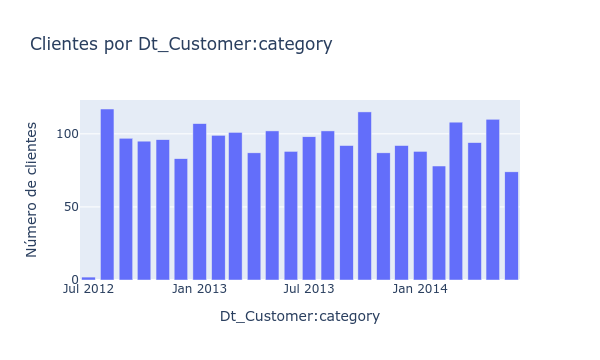

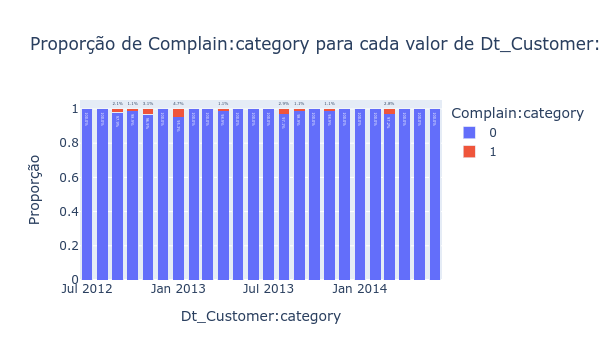

In [26]:
from brandedpipes import __
df['Dt_Customer:category'] = (
    df['Dt_Customer']
        .astype(str)
        .apply(
            lambda s: __| s.split('-')[1:] | reversed | '-'.join |__
        )
)
count_bars(df, 'Dt_Customer:category')
proportion_bars(df, 'Dt_Customer:category')

Novamente, vemos uma distribuição não muito surpreendente. Os cadastros, sendo recentes, provavelmente estão em um momento de pico, o que não permitiria uma curva normal ou de Poisson.

### Coluna `Recency`

Esta é a coluna conta os dias desde a última compra. Vejamos sua distribuição:

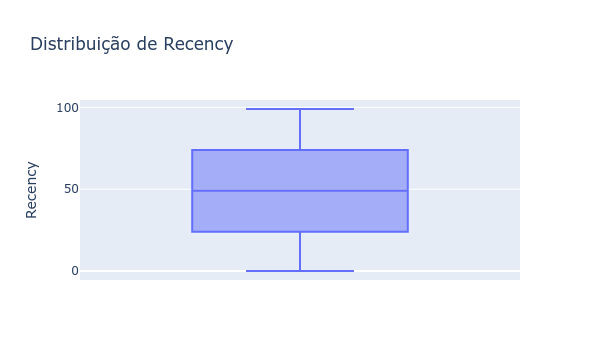

In [27]:
boxplot(df, 'Recency')

Parece ser um valor muito bem distribuído entre 0 dias e 99 dias. Como isso afeta sua distribuição?

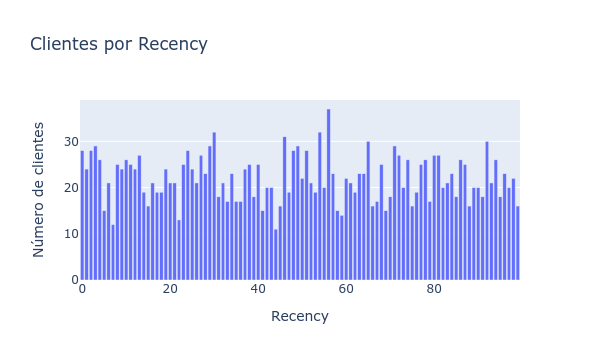

In [28]:
count_bars(df, 'Recency')

A distribuição dos dias parece seguir algo entre uma curva senoidal e uma distribuiçaõ uniforme. Vejamos como é a proporção das reclamçaões por dia:

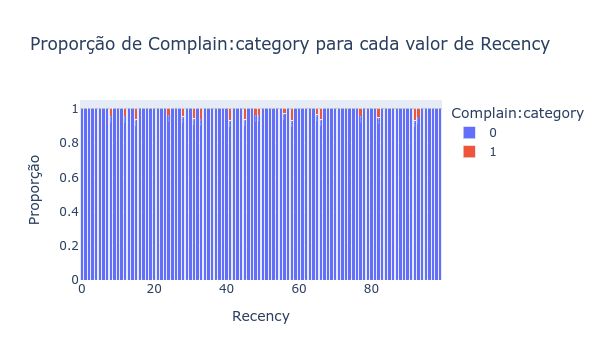

In [29]:
proportion_bars(df, 'Recency')

Também parece uniforme, embora acha pequenos blocos (que poderiam também indicar certa sazonalidade).

### Colunas de produtos

Temos colunas que detemrinam quanto o cliente gastou em algumas categorias específicas: vinhos, frutas, carne, peixe, ouro. Vejamos seus boxplots:

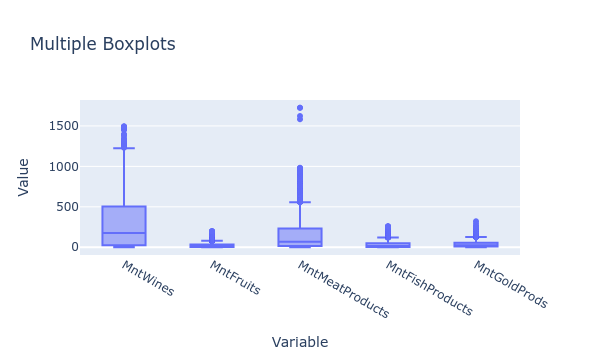

In [30]:
products_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", 'MntGoldProds']
df_melted = df.melt(value_vars=products_columns,
                    var_name="Variable", value_name="Value")

fig = px.box(df_melted, x="Variable", y="Value", title="Multiple Boxplots")
fig.show()



Todas têm alguns outliers de valores altos, o que faz sentido (existe um limite intransponivel para o valor baixo, obviamente). Carne tem outlines bem mais fortes. Ainda assim, não nos parecem tão absurdos que tenhamos de tirá-los.

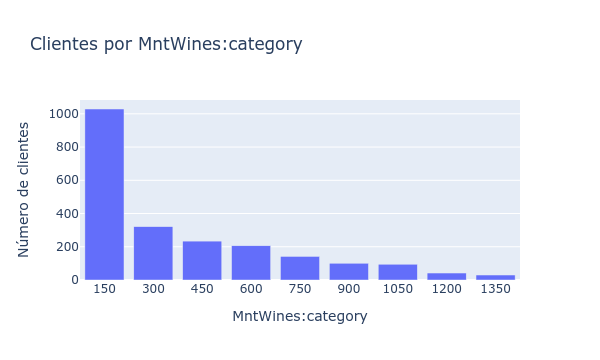

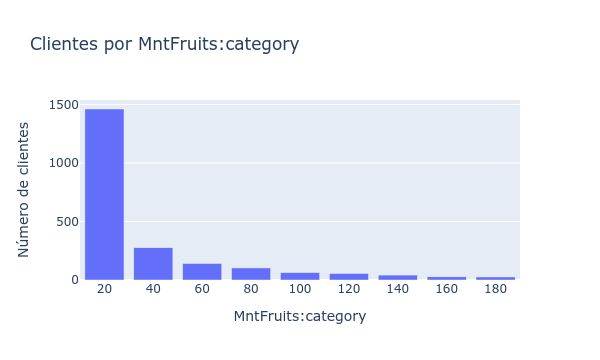

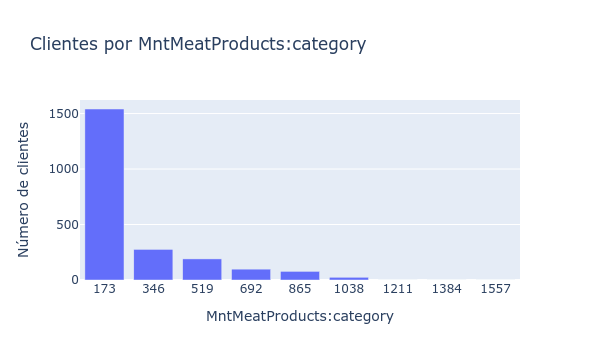

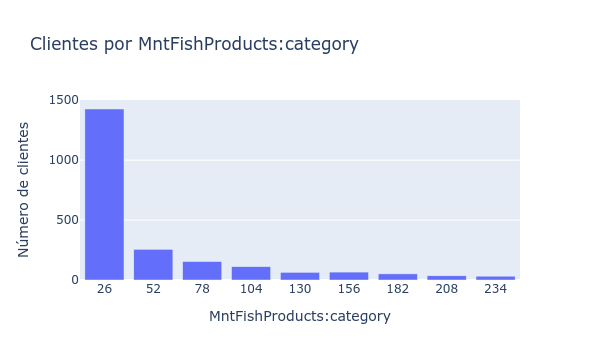

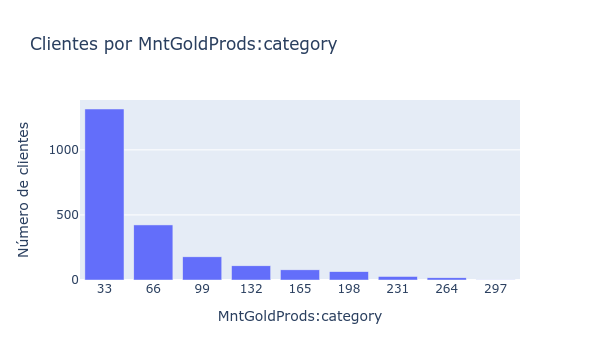

In [31]:
import math
def set_bins(df, column, min=None, max=None, count=10):
    series = df[column]
    min = series.min() if min is None else min
    max = series.max() if max is None else max
    interval = (max-min)/count
    bins = list(range(math.floor(min), math.ceil(max), math.ceil(interval)))
    labels = [str(b) for b in bins[1:]]
    df[f'{column}:category'] = pd.cut(
        df[column], bins=bins, labels=labels, include_lowest=True
    )
    
for c in products_columns:
    set_bins(df, c, min=0)
    count_bars(df, f'{c}:category')

    

Os valores gastos seguem basicamente a mesma distribuição de calda longa, vagamente parecida com Poisson. Vejamos a proporição de reclamações:

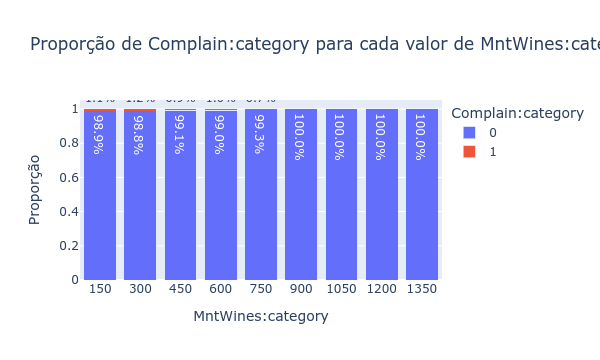

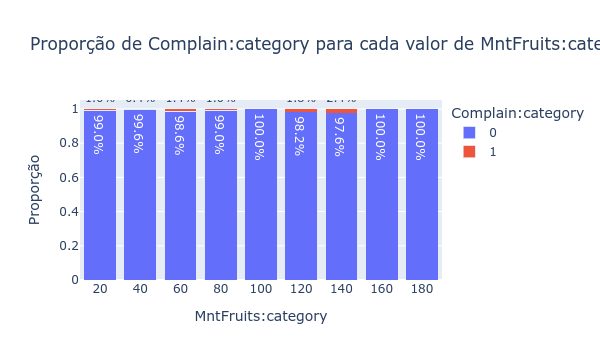

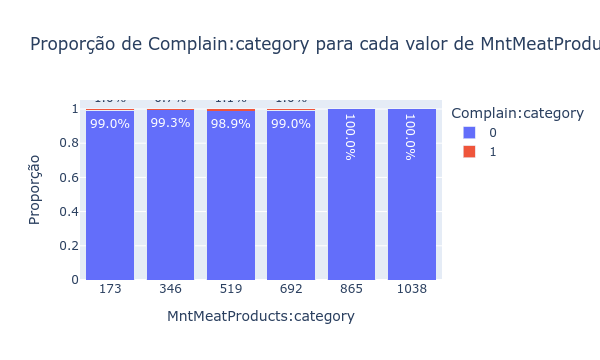

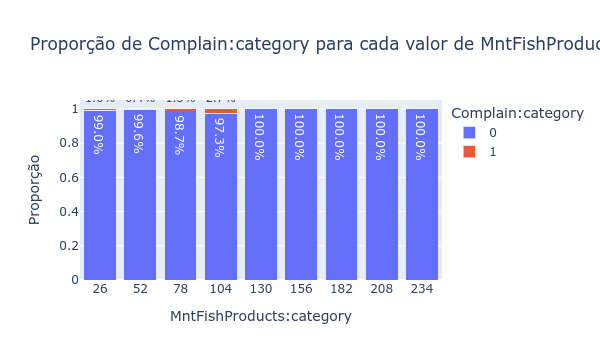

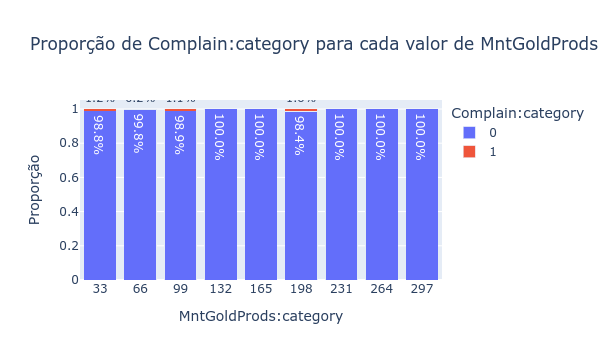

In [32]:
for c in products_columns:
    proportion_bars(df, f'{c}:category')

As proporções variam consideravelmente, dependendo do produto. Interessante, isso pode significar que o consumo de produtos pode realmente ajudar a prever reclamações.

### Coluna `NumWebVisitsMonth`

Temos uma coluna que informa quantas vezes o usuário acessou o site. Vejamos como seus valores se espalham:

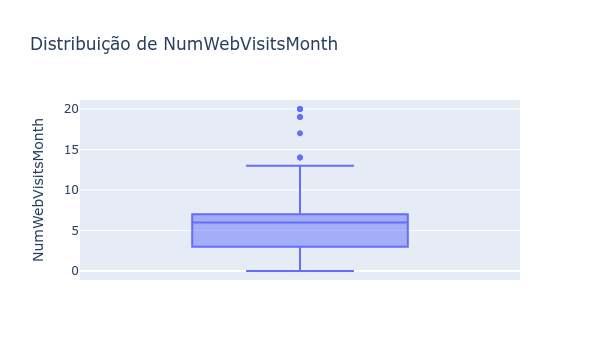

In [33]:
boxplot(df, 'NumWebVisitsMonth')

Temos um formato similar à distribuição exponencial, tão comum nesses casos. O gráfico de barras confirma isso:

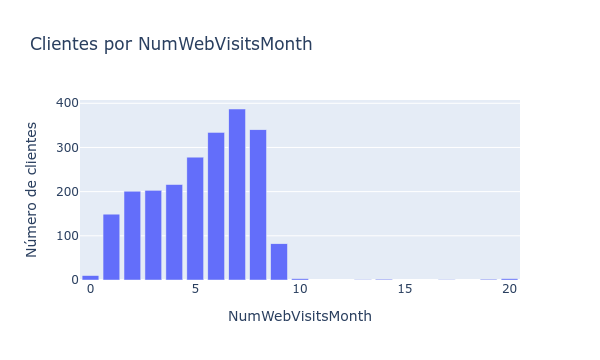

In [34]:
count_bars(df, 'NumWebVisitsMonth')

É um tanto irregular (a cauda cai drasticamente e se extende irregularmente). Se estivéssemos tentando fazer um modelo parametrizado, poderíamos tentar fazer alguns bins aqui.

### Colunas de uso de canais

Temos os números de compras feitos em canais diferentes:

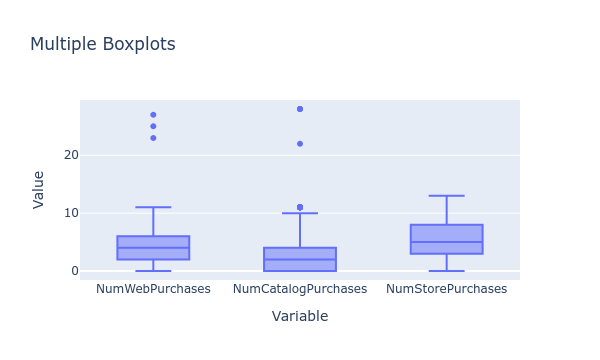

In [35]:
channel_columns = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
df_melted = df.melt(value_vars=channel_columns,
                    var_name="Variable", value_name="Value")

fig = px.box(df_melted, x="Variable", y="Value", title="Multiple Boxplots")
fig.show()

Enquanto podemos notar alguns outliners, nenhum é muito extremo. Pelo contrário, é o tipo de variação que poderíamos esperar do uso de canais de compra diferentes.

Ver a distribuição poderá nos dar uma noção melhor:

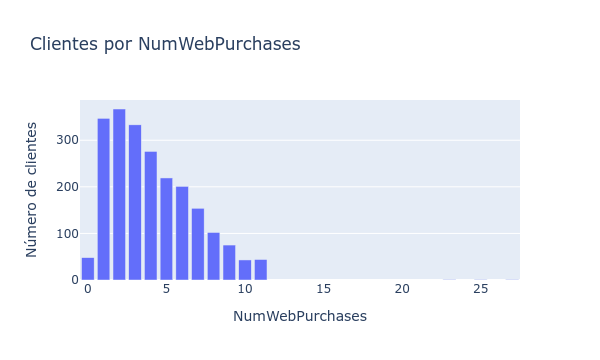

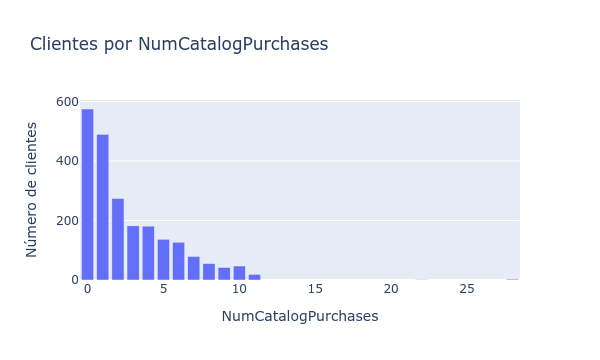

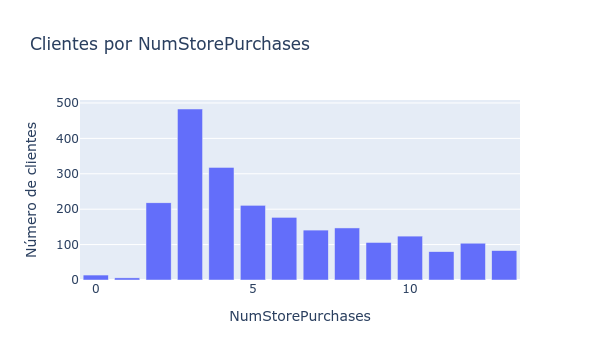

In [36]:
for c in channel_columns:
    count_bars(df, c)


Vemos uma distribuição de cauda à direnta,  vagamente similar a distribuições exponenciais. De fato, eles se parecem bastante com **distribuições de Poisson**, sendo que o $\lambda$ é maior à medida em que o canal se tornal mais tradicional ou popular.

Vejamos então as proporções de reclamações para os canais:

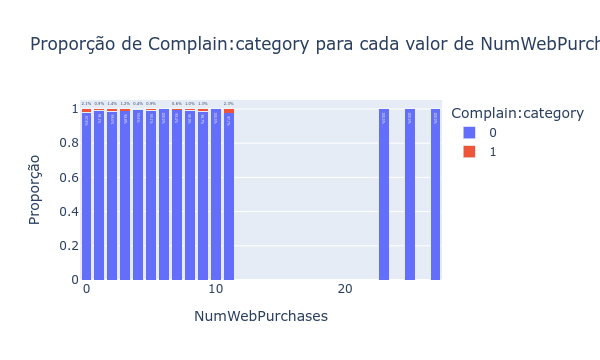

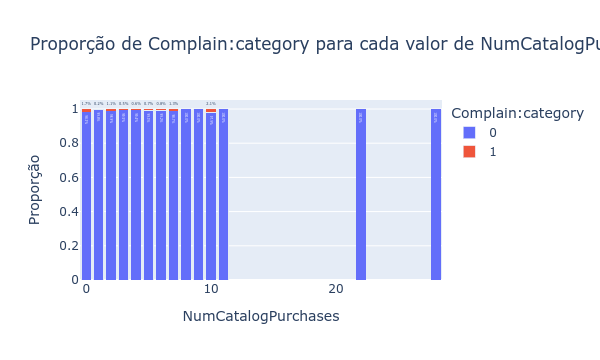

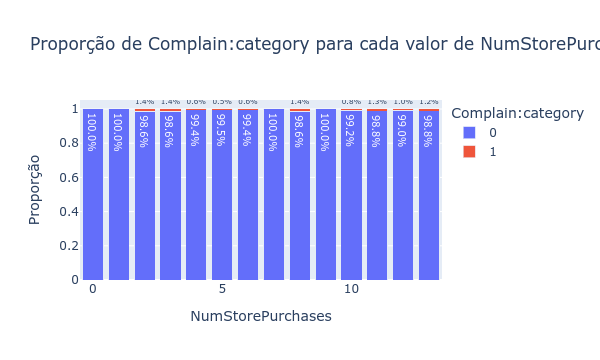

In [37]:
for c in channel_columns:
    proportion_bars(df, c)

Em geral, não se nota muitas distinções entre canais no que se refere a reclamações.

#### Coluna derivada: `PreferredChannel`

Podemos derivar uma coluna bem interessante desses valores: o canal de preferência do cliente. Nós não vamos adicioná-las, porque na hora de rodar um modelo teríamos de usar algo como one-hot enconding, que poderia ser altamente correlacionado com as colunas que já existem. Mas vamos criar em um data frame separado só para propósitos de análise:

In [38]:
import numpy as np
exploratory_df = pd.DataFrame({
    'Complain:category': df['Complain:category'],
    'PreferredChannel': df[['NumStorePurchases', 'NumWebPurchases', 'NumCatalogPurchases']].idxmax(axis=1)
})
exploratory_df

Complain:category     PreferredChannel
0                    0  NumCatalogPurchases
1                    0    NumStorePurchases
2                    0    NumStorePurchases
3                    0    NumStorePurchases
4                    0    NumStorePurchases
...                ...                  ...
2235                 0      NumWebPurchases
2236                 0      NumWebPurchases
2237                 0    NumStorePurchases
2238                 0    NumStorePurchases
2239                 0    NumStorePurchases

[2212 rows x 2 columns]

Vejamos como é a distribuição:

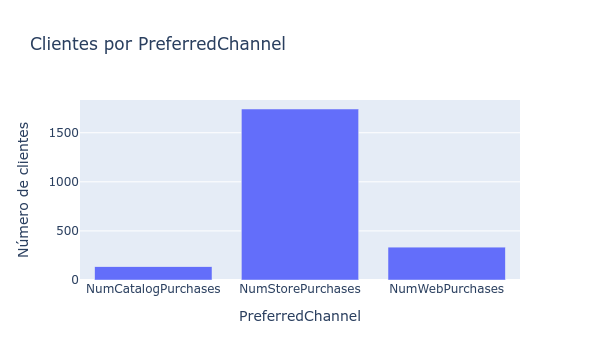

In [39]:
count_bars(exploratory_df, 'PreferredChannel')

Não é realmente uma surpresa que lojas sejam o principal canal, seguido de sites.

Vejamos como isso afeta as reclamações:

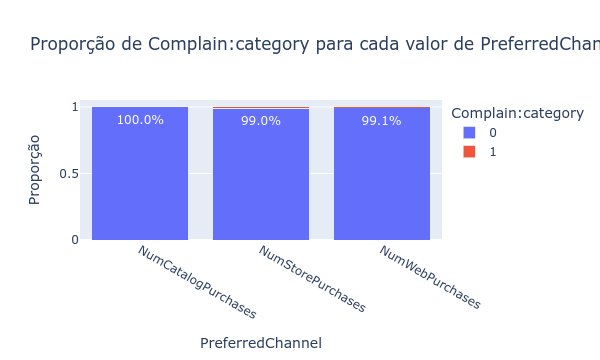

In [40]:
proportion_bars(exploratory_df, 'PreferredChannel')

Catálogos não levam a reclamação nenhuma (o que tem certa lógica: são menos interativos, então é mais difícil reclamar.)

Por outro lado, proporcionalmente, lojas e site geram a mesma proporção de reclamações.

### Colunas de respostas a campanhas: `NumDealsPurchases`

Temos algums colunas que refletem a resposta de clientes a campanhas de marketing. Uma delas é `NumDealsPurchases`, cujo nome parece se referir a um canal, mas não é o caso (afinal, podemos fazer "deals" por qualquer canal). Vejamos sua distribuição:

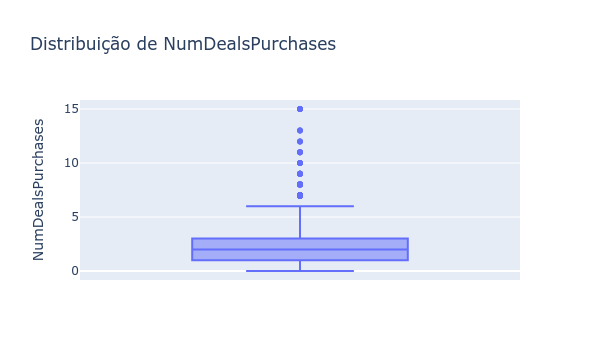

In [41]:
boxplot(df, 'NumDealsPurchases')

Vemos novamente esse padrão comum, de outliers de valores mais altos relativamente bem distribuídos, como  uma distribuição exponencial. Essa métrica tem um formato bem similar às métricas de canal, de fato.

Mais interessantes, provavelmente, seriam as respostas às campanhas.

### Colunas de respostas a campanhas: `Accepted...`

Nesse dataset, presume-se que há dados sobre 6 campanhas relacionadas. Sabemos se os clientes responderam a cada ma delas. 

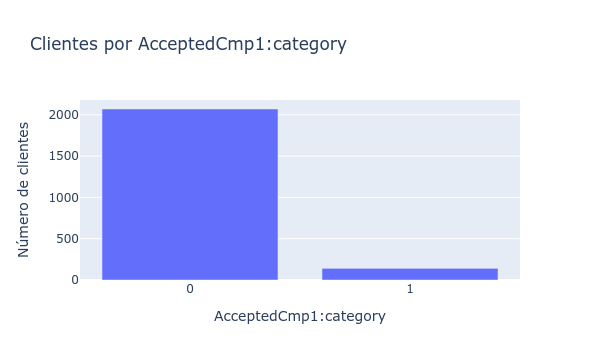

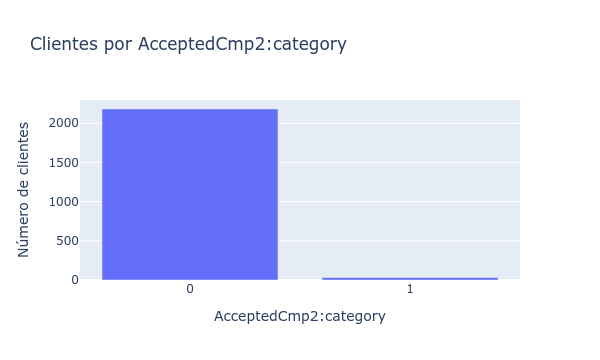

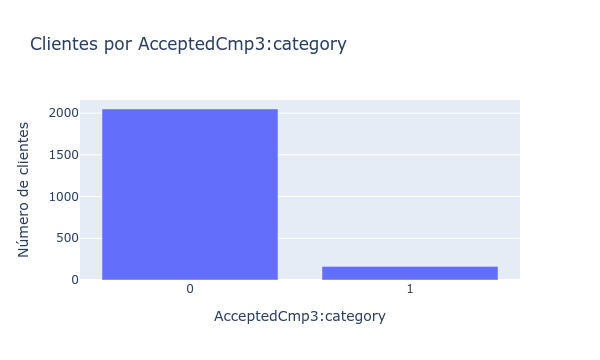

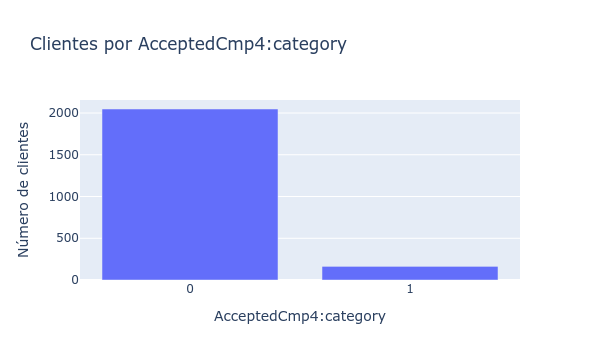

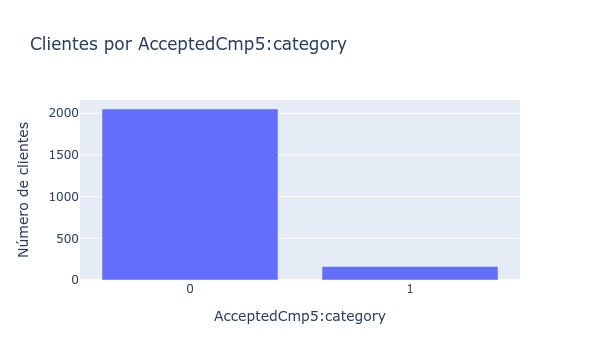

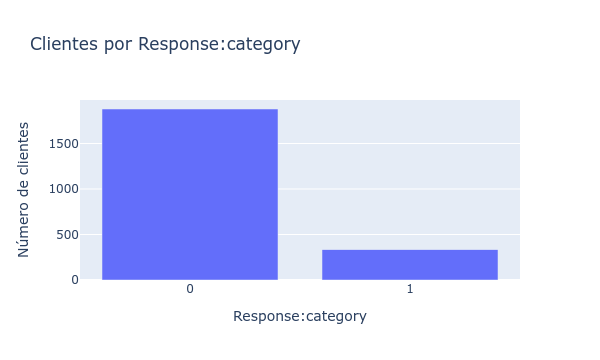

In [42]:
response_columns = [f'AcceptedCmp{i}' for i in range(1, 6)] + ['Response']

for c in response_columns:
    df[f'{c}:category'] = df[c].astype(str)
    count_bars(df, f'{c}:category')

Como é a proporção das reclamações:

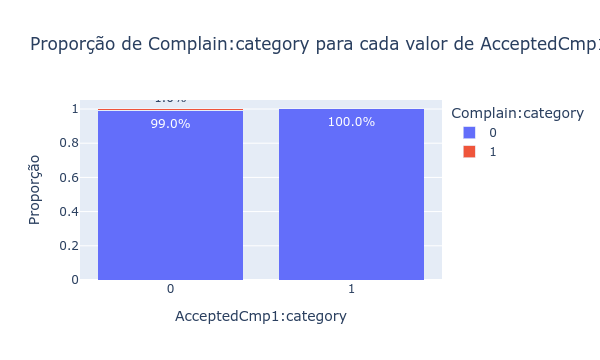

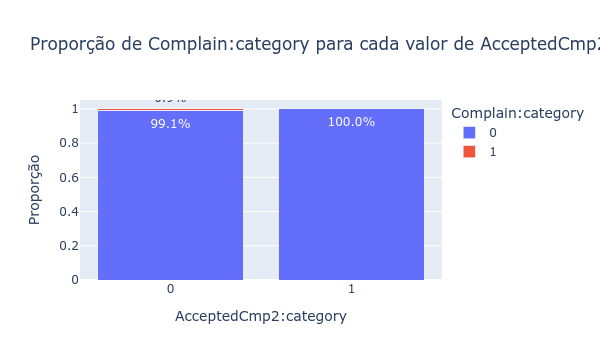

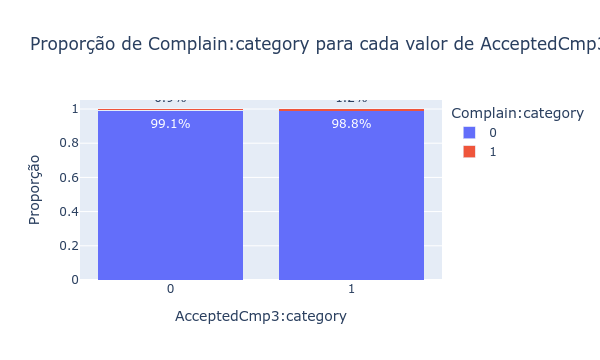

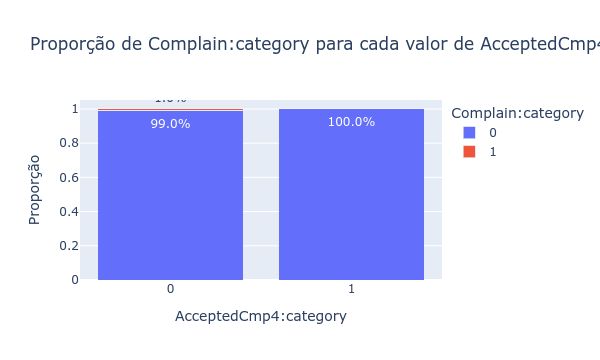

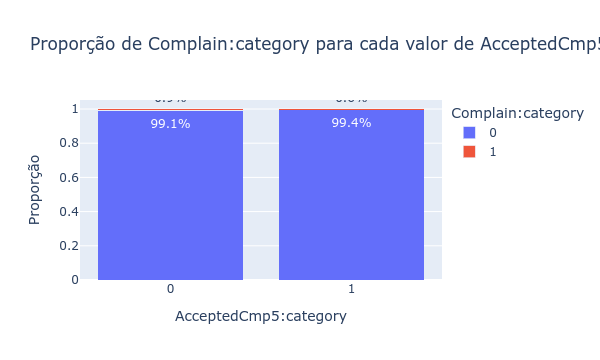

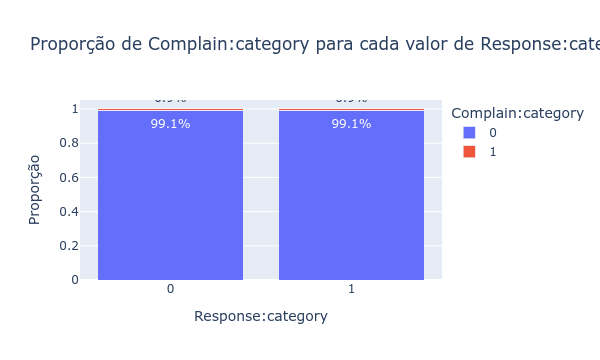

In [43]:
for c in response_columns:
    proportion_bars(df, f'{c}:category')

Interessantemente, a reclamação pode variar bastante dependndo da campanha, mas isso parece coincidência
#### Coluna derivada: `FirstResponse`

Podemos gerar uma informação bem interessante: a primeira campanha a ser respondida. Vamos criar essa coluna:

In [44]:
import numpy as np
conditions = [
    df['AcceptedCmp1'] != 0,
    df['AcceptedCmp2'] != 0,
    df['AcceptedCmp3'] != 0,
    df['AcceptedCmp4'] != 0,
    df['AcceptedCmp5'] != 0,
    df['Response'] != 0,
]
choices = range(1, 7) 
exploratory_df[response_columns] = df[response_columns]
exploratory_df['FirstResponse'] = np.select(conditions, choices, default=0)
exploratory_df[response_columns+['FirstResponse']][exploratory_df['FirstResponse']!=0]

AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
0                0             0             0             0             0   
8                0             0             0             0             0   
9                0             0             1             0             0   
15               1             0             0             0             1   
18               1             0             0             0             0   
...            ...           ...           ...           ...           ...   
2224             0             0             1             0             0   
2230             0             0             1             0             0   
2236             1             0             0             0             0   
2237             0             0             0             1             0   
2239             0             0             0             0             0   

      Response  FirstResponse  
0            1              6  
8            1              6  
9            0              3  
15           1              1  
18           0              1  
...        ...            ...  
2224         0              3  
2230         0              3  
2236         0              1  
2237         0              4  
2239         1              6  

[604 rows x 7 columns]

Será que essa coluna terá uma distribuição interessante? Vejamos:

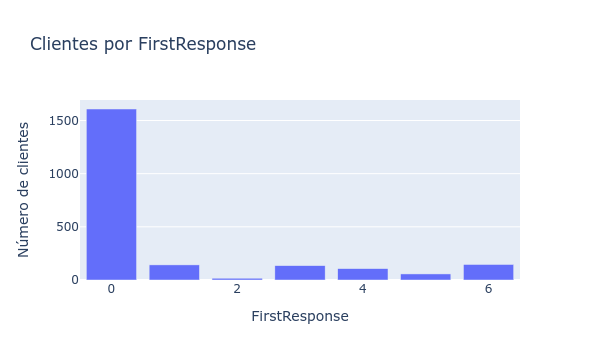

In [45]:
count_bars(exploratory_df, 'FirstResponse')

Notamos que a maioria dos clientes não participa de nenhuma promoção. Mais notavelmente, muitos responderam na sexta campanha: isso pode indicar que fazer tal número de campanhas.

Mas o quanto isso afeta as reclamações? Vejamos as proporções.

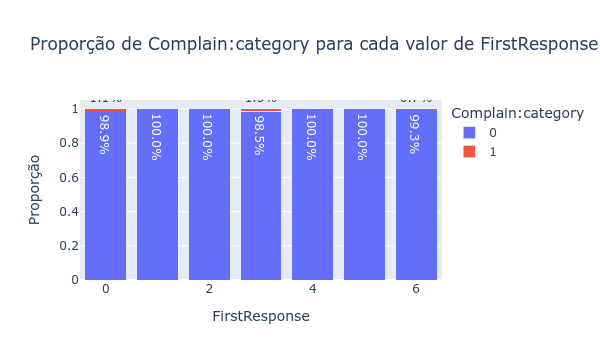

In [46]:
proportion_bars(exploratory_df, 'FirstResponse')

Embora alguns clientes da terceira e sexta campanha tenham reclamado, parece o caso de que clientes que participam de promoções não reclamam muito.

## Diagnóstico e limpeza de dados

Vamos agora verificar alguns aspectos de "saúde da base."

### Remoção de categorias exploratórias

Na nossa análise, criamos várias colunas de categorias baseadas em valores numéricos (e.g. binning). Elas não são necessárias no treinamento do modelo: pelo contrário, adicionariam mais parâmetros (com one-hot enconding) e poderiam gerar até correlações desnecessárias. Vamos remover essas colunas:

In [47]:
exploratory_categories = [c for c in df.columns if c.endswith(':category')]
df.drop(exploratory_categories, axis=1, inplace=True)
df.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0        1957  Graduation         Single  58138.0        0         0   
1        1954  Graduation         Single  46344.0        1         1   
2        1965  Graduation       Together  71613.0        0         0   
3        1984  Graduation       Together  26646.0        1         0   
4        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  ...  NumCatalogPurchases  \
0  04-09-2012       58       635         88  ...                   10   
1  08-03-2014       38        11          1  ...                    1   
2  21-08-2013       26       426         49  ...                    2   
3  10-02-2014       26        11          4  ...                    0   
4  19-01-2014       94       173         43  ...                    3   

   NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0                  4                  7             0             0   
1                  2                  5             0             0   
2                 10                  4             0             0   
3                  4                  6             0             0   
4                  6                  5             0             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0             0             0             0         0         1  
1             0             0             0         0         0  
2             0             0             0         0         0  
3             0             0             0         0         0  
4             0             0             0         0         0  

[5 rows x 26 columns]

### Valores nulos

Aqui vale verificar um fator muito importante. Há colunas cujo valor é nulo? Vamos verificar:

In [48]:
pd.DataFrame({
    'factor': df.columns,
    'null': [df[c].isnull().any() for c in df.columns]
})

factor   null
0            Year_Birth  False
1             Education  False
2        Marital_Status  False
3                Income  False
4               Kidhome  False
5              Teenhome  False
6           Dt_Customer  False
7               Recency  False
8              MntWines  False
9             MntFruits  False
10      MntMeatProducts  False
11      MntFishProducts  False
12     MntSweetProducts  False
13         MntGoldProds  False
14    NumDealsPurchases  False
15      NumWebPurchases  False
16  NumCatalogPurchases  False
17    NumStorePurchases  False
18    NumWebVisitsMonth  False
19         AcceptedCmp3  False
20         AcceptedCmp4  False
21         AcceptedCmp5  False
22         AcceptedCmp1  False
23         AcceptedCmp2  False
24             Complain  False
25             Response  False

Apenas `Income` possui valores nulos. Vejamos quantos são:

In [49]:
sum(df_raw['Income'].isnull())

24

Isso significa que, temos 24 valores nulos em `Income`, que é pouco mais de 1% do total de linhas. A princípio, não nos preocupamos com isso: até segunda ordem, vamos apenas manter esse fato em mente. Se necessário, podemos eventualmente preencher com dados sintéticos, mas por ora vamos apenas manter os valores nulos, já que eles mesmos podem ser informativos, em teoria.

Mais preoucupante é o...

### Desbalanceamento

Como visto acima, nossa coluna de rótulos é profundamente desbalanceada:

In [50]:
complain_df

Complain  count
0         0   2219
1         1     21

Com esse nível de desbalanceamento, será prudente escolher modelos que sejam mais robustos diante de desbalanceamento. Mesmo para esses modelos, podemos melhorar essa situação balanceando os dados (por exemplo, com SMOTEN).

## Preprocessamento de dados

Vamos preparar os dados para rodar modelos neles. Atevemos três passos necessários:

* Separar fatores e rótulos;
* Expandir os campos de data (no caso, `Dt_Customer`) par valores numéricos;
* Balancear a base;
* Aplicar one-hot encoding.

### Separação de fatores e rótulos

Esta parte é trivial: apenas geramos as variáveis `X` e `Y`:

In [51]:
X = df.drop(columns=['Complain'])
Y = df['Complain']

### Expandindo `datetime` da coluna `Dt_Customer`

Também precisamos converter o valor `Dt_Customer` para algo que não seja `datetime`. Vamos converter para os valores de ano, mês e dia, ao invés de um timestamp, por três razões:

1. Esse campo é uma data, não tem hora, logo um timestamp teria _dados demais_;
2. É interessante pensar que ano, mês e dia podem, talvez, influenciar o modelo se isolados;
3. É mais fácil de ler e interpretar.

Abaixo, convertemos a coluna apropriadamente:

In [52]:
dt_customer = pd.to_datetime(X['Dt_Customer'], format='%d-%m-%Y')
X['Dt_Customer:year'] = dt_customer.dt.year
X['Dt_Customer:month'] = dt_customer.dt.month
X['Dt_Customer:day'] = dt_customer.dt.day
X.drop('Dt_Customer', axis=1, inplace=True)

### Balanceamento com SMOTENC

Para obter melhores resultados, vamos balancear a base com SMOTENC. Primeiro, vejamos quais são nossas colunas:

In [53]:
X.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Dt_Customer:year', 'Dt_Customer:month', 'Dt_Customer:day'],
      dtype='object')

Apenas `Education`  and `Marital_Status` são categóricas:

In [54]:
categorical_columns = ['Education', 'Marital_Status']
numeric_columns = [c for d in X.columns if c not in categorical_columns]

Façamos o desbalanceamento

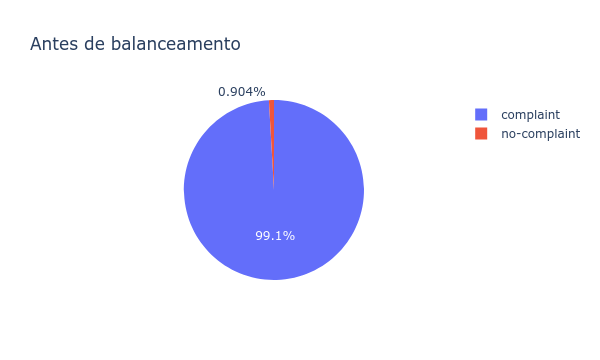

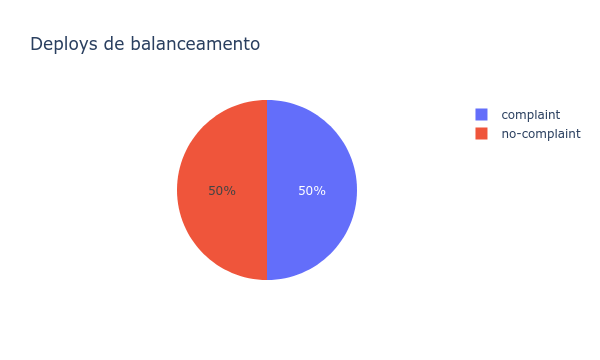

counts
Complain        
0           2192
1           2192

In [55]:
from imblearn.over_sampling import SMOTENC

def show_dataset_balance(df, title):
    counts = df.value_counts()
    counts_df = pd.DataFrame(dict(counts=counts), index=counts.index)
    counts_graph = px.pie(
        title=title,
        values=counts_df['counts'],
        names=['complaint', 'no-complaint']
    )
    counts_graph.show()
    return counts_df

show_dataset_balance(Y, 'Antes de balanceamento')

smotenc = SMOTENC(
    categorical_features=[c in categorical_columns for c in X.columns], random_state=42)
X, Y = smotenc.fit_resample(X, Y)

show_dataset_balance(Y, 'Deploys de balanceamento')

Bem melhor! Agora, vamos tratar as categorias


### One-hot enconding

Com isso, Essas são as colunas de nosso data frame:

In [56]:
df.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

Logo, as categorias são:

In [57]:
category_columns = [
    'Education',
    'Marital_Status',
]

...e então aplicar one-hot encoding:

In [58]:
X = pd.get_dummies(X, columns=category_columns, dummy_na=True, drop_first=False)
ohe_columns = X.columns
ohe_columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Dt_Customer:year', 'Dt_Customer:month',
       'Dt_Customer:day', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Education_nan', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO', 'Marital_Status_nan'],
      dtype='object')

**NOTE**: Não precisamos descartar a primeira categoria porque não vamos usar modelos logísticos ou lineares.

Com o preprocessamento feito, podemos partir para treinar modelos.

## Treinamento de modelos

Nós balanceamos nosso dataset, mas ainda assim, daremos preferência a modelos que funcionem melhor em datasets desbalanceados. Isso já nos faz desconsiderar

* modelos logísticos (que já não usaríamos mesmo);
* KNN;
* Native Bayes.

Vamos então explorar dois modelos:   

1. Random forest (bagging);
2. CatBoost (boosting).

Antes de mais nada, porém, vamos criar conjuntos de treinamento e teste:

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

### Random Forest

Criemos um modelo com random forest:

In [70]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Avaliemos a performance do modelo agora:

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def evaluate_model(model, X_test, y_test):
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_prob)

    return pd.DataFrame(
        
        {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
        'Value': [f'{accuracy:.4f}', f'{precision:.4f}', f'{recall:.4f}', f'{f1:.4f}', f'{roc_auc:.4f}'],
        }
    )

evaluate_model(rf_model, X_test, y_test)

Metric   Value
0   Accuracy  0.9970
1  Precision  0.9970
2     Recall  0.9970
3   F1 Score  0.9970
4    ROC-AUC  0.9999

Those are remarkably good values! Random Forest did work well with our data.

### CatBoost

Agora, vamos testar CatBoost:


In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=100, random_state=42, verbose=False)

rf_model.fit(X_train, y_train)